# border distance training
add DBP for training the autoencoder
- train_data, ifgsm_augmentation_data, DBP with modified parametric_umap_DBP -> encoder_DBP

## import modules

In [1]:
import torch
import math

import numpy as np
import torchvision
import torchvision.transforms as transforms
# from torch.utils.tensorboard import SummaryWriter
from tensorboardX import SummaryWriter
from cifar10_models import *

In [2]:
INPUT_SIZE = 2048
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
# load model
model = resnet50(pretrained=True)
model.eval()
model.to(device)
print("Load Model successfully...")

Load Model successfully...


In [4]:
# hyperparameters
data_shape = (2048,)

ADD_NOISE = False
n_hidden = 500
dim_img = INPUT_SIZE  # number of pixels for a MNIST image
dim_z = 2

# train
n_epochs = 500
batch_size = 200
learn_rate = 0.001

In [ ]:
# CIFAR10 Test dataset and dataloader declaration
CIFAR_NORM = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(*CIFAR_NORM)])

trainset = torchvision.datasets.CIFAR10(root='data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=200,
                                          shuffle=True, num_workers=0)
training_data = np.zeros((50000, 3, 32, 32))

for i, (data, target) in enumerate(trainloader, 0):
    r1, r2 = i * 200, (i + 1) * 200
    training_data[r1:r2] = data
training_data.shape

Files already downloaded and verified


In [ ]:
train_pred_labels = np.zeros(50000)
raw_input_X = torch.from_numpy(training_data).to(device, dtype=torch.float)
input_X = np.zeros([len(raw_input_X), data_shape[0]])
output_Y = np.zeros(len(raw_input_X))
n_batches = max(math.ceil(len(raw_input_X) / batch_size), 1)
for b in range(n_batches):
    r1, r2 = b * batch_size, (b + 1) * batch_size
    inputs = raw_input_X[r1:r2]
    with torch.no_grad():
        pred = model.gap(inputs).cpu().numpy()
        input_X[r1:r2] = pred
        pred = model(inputs).cpu().numpy().argmax(axis=1)
        output_Y[r1:r2] = pred
train_data = input_X    # (50000,2048)
train_pred_labels = output_Y
train_data.shape, train_pred_labels.shape

In [28]:
np.save("train_data.npy",train_data)
np.save("train_pred_labels.npy",train_pred_labels)

In [3]:
train_data = np.load("train_data.npy")
train_pred_labels = np.load("train_pred_labels.npy")

In [2]:
border_center = np.load("border_center.npy")
border_center_labels= np.load("border_center_labels.npy")
augmentation_data = np.load("augmentation_data.npy")
border_center.shape, border_center_labels.shape, augmentation_data.shape

((5000, 2048), (5000,), (50000, 2048))

In [5]:
batch_size = 500

train_num = 45000
augmentation_num = 10000
border_num = 5000

fitting_data = np.concatenate((train_data[-train_num:],
                               augmentation_data[:augmentation_num],
                               border_center[:border_num]), axis=0)
fitting_data.shape

(60000, 2048)

In [3]:
fitting_data = border_center

In [4]:
# define encoder
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## define training process

In [5]:
# number of trees in random projection forest
n_trees = 5 + int(round((fitting_data.shape[0]) ** 0.5 / 20.0))
# max number of nearest neighbor iters to perform
n_iters = max(5, int(round(np.log2(fitting_data.shape[0]))))
# distance metric
metric = "euclidean"
# number of neighbors for computing k-neighbor graph
n_neighbors = 10

In [ ]:
from pynndescent import NNDescent
# get nearest neighbors
nnd = NNDescent(
    fitting_data.reshape((len(fitting_data), np.product(np.shape(fitting_data)[1:]))),
    n_neighbors=n_neighbors,
    metric=metric,
    n_trees=n_trees,
    n_iters=n_iters,
    max_candidates=60,
    verbose=True
)

In [ ]:
from sklearn.utils import check_random_state
from umap.umap_ import fuzzy_simplicial_set
knn_indices, knn_dists = nnd.neighbor_graph
random_state = check_random_state(None)

In [ ]:
umap_graph, sigmas, rhos = fuzzy_simplicial_set(
    X=fitting_data,
    n_neighbors=n_neighbors,
    metric=metric,
    random_state=random_state,
    knn_indices=knn_indices,
    knn_dists=knn_dists,
)

## define autoencoder

In [11]:
# from parametric_umap_DBP import construct_edge_dataset
# from parametric_umap_DBP import umap_loss
from parametric_umap_DBP import construct_edge_dataset
from parametric_umap_DBP import umap_loss

In [ ]:
from parametric_umap import construct_edge_dataset
from parametric_umap import umap_loss

In [ ]:
N = 100

dims = (2048,)
n_components = 2

n_epochs = 200 
batch_size = 1000

In [ ]:
encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=dims),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1024, activation="relu"),
    tf.keras.layers.Dense(units=n_components),
])
encoder.summary()

In [ ]:
# define the decoder
decoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(n_components)),
    tf.keras.layers.Dense(units=1024, activation="relu"),
    tf.keras.layers.Dense(units=np.product(dims), name="recon", activation=None),
    tf.keras.layers.Reshape(dims),

])
decoder.summary()

In [16]:
(
    edge_dataset,
    batch_size,
    n_edges,
    head,
    tail,
    edge_weight,
) = construct_edge_dataset(
    (fitting_data, border_center),
    umap_graph,
    n_epochs,
    batch_size,
    parametric_embedding = True,
    parametric_reconstruction = True,
)

In [17]:
# define model
# network outputs
outputs = {}

# inputs
to_x = tf.keras.layers.Input(shape=dims, name="to_x")
from_x = tf.keras.layers.Input(shape=dims, name="from_x")
dbp_x = tf.keras.layers.Input(shape=dims, name="dbp_x")
inputs = (to_x, from_x, dbp_x)

# parametric embedding
embedding_to = encoder(to_x)
embedding_from = encoder(from_x)
embedding_dbp = encoder(dbp_x)

# parametric reconstruction
embedding_to_recon = decoder(embedding_to)

embedding_to_recon = tf.keras.layers.Lambda(
    lambda x: x, name="reconstruction"
)(embedding_to_recon)

outputs["reconstruction"] = embedding_to_recon

# concatenate to/from projections for loss computation
embedding_to_from = tf.concat((embedding_to, embedding_from, embedding_dbp), axis=1)
embedding_to_from = tf.keras.layers.Lambda(lambda x: x, name="umap")(
    embedding_to_from
)
outputs["umap"] = embedding_to_from

# create model
parametric_model = tf.keras.Model(inputs=inputs, outputs=outputs,)

In [18]:
from umap.umap_ import find_ab_params
min_dist = 0.1
_a, _b = find_ab_params(1.0, min_dist)

In [19]:
batch_szie = 200
negative_sample_rate = 5
optimizer = tf.keras.optimizers.Adam(1e-3)

In [23]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 5:
        lr *= 1e-1
    elif epoch > 15:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        min_delta=10**-2,
        patience=10,
        verbose=1,
    ),
    tf.keras.callbacks.TensorBoard(log_dir='logs/mse/',histogram_freq=1),
    tf.keras.callbacks.LearningRateScheduler(lr_schedule),
#     tf.keras.callbacks.ReduceLROnPlateau(factor=np.sqrt(0.1),
#                                cooldown=0,
#                                patience=5,
#                                min_lr=0.5e-6)
]

In [25]:
#compile models
losses = {}
loss_weights = {}

umap_loss_fn = umap_loss(
    batch_size,
    negative_sample_rate,
    _a,
    _b,
    edge_weight,
    True,
)
losses["umap"] = umap_loss_fn
loss_weights["umap"] = 1.0

losses["reconstruction"] = tf.keras.losses.MeanSquaredError()
loss_weights["reconstruction"] = 1.0

parametric_model.compile(
    optimizer=optimizer, loss=losses, loss_weights=loss_weights,
)

## fitting model

In [21]:
steps_per_epoch = int(
    n_edges / batch_size / 5
)

In [26]:
# create embedding
history = parametric_model.fit(
    edge_dataset,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    callbacks=callbacks,
    max_queue_size=100,
)

Epoch 1/20
Learning rate:  0.001
630/630 [==============================] - 19s 29ms/step - loss: 0.0844 - reconstruction_loss: 8.0042e-04 - umap_loss: 0.0836
Epoch 2/20
Learning rate:  0.001
630/630 [==============================] - 17s 27ms/step - loss: 0.0833 - reconstruction_loss: 8.1237e-04 - umap_loss: 0.0825
Epoch 3/20
Learning rate:  0.001
630/630 [==============================] - 17s 27ms/step - loss: 0.0833 - reconstruction_loss: 7.8580e-04 - umap_loss: 0.0825
Epoch 4/20
Learning rate:  0.001
630/630 [==============================] - 17s 27ms/step - loss: 0.0817 - reconstruction_loss: 7.3968e-04 - umap_loss: 0.0809
Epoch 5/20
Learning rate:  0.001
630/630 [==============================] - 17s 27ms/step - loss: 0.0822 - reconstruction_loss: 8.7747e-04 - umap_loss: 0.0813
Epoch 6/20
Learning rate:  0.001
630/630 [==============================] - 17s 27ms/step - loss: 0.0815 - reconstruction_loss: 8.0195e-04 - umap_loss: 0.0807
Epoch 7/20
Learning rate:  0.0001
630/630 [===

In [27]:
import matplotlib.pyplot as plt

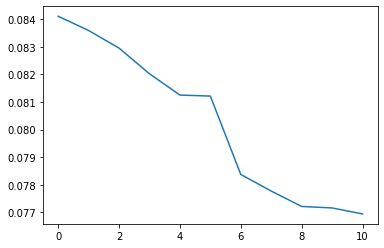

In [28]:
plt.plot(history.history['loss'])

In [29]:
z = encoder.predict(train_data)

Text(0.5, 1.0, 'UMAP embeddings')

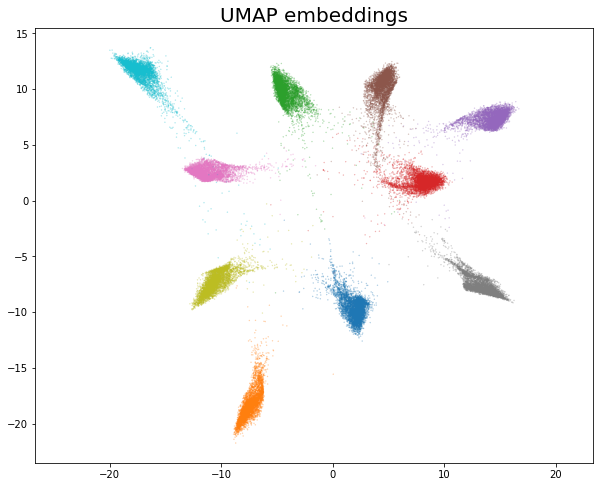

In [30]:
fig, ax = plt.subplots(ncols=1, figsize=(10, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=train_pred_labels,
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP embeddings", fontsize=20)

In [31]:
# save
import os

save_location = "parametric_umap_models\parametric_umap_autoencoder"
# # save encoder
encoder_output = os.path.join(save_location, "encoder_DBP")
encoder.save(encoder_output)
print("Keras encoder model saved to {}".format(encoder_output))

# # save decoder
decoder_output = os.path.join(save_location, "decoder_DBP")
decoder.save(decoder_output)
print("Keras decoder model saved to {}".format(decoder_output))


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: parametric_umap_models\parametric_umap_autoencoder\encoder_DBP\assets
Keras encoder model saved to parametric_umap_models\parametric_umap_autoencoder\encoder_DBP

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: parametric_umap_models\parametric_umap_autoencoder\decoder_DBP\assets
Keras decoder model saved to parametric_umap_models\parametric_umap_autoencoder\decoder_DBP
